In [ ]:
import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.chdir('./Final+paper/NIKL_DIALOUGUE_2023')

In [ ]:
filelist = os.listdir()[2:]

In [ ]:
len(filelist)

1974

----------------------------------------
- 1) 화자 metadata 시각화
    - 화자 명수 시각화
    - 화자 명수, 성별 정보쌍 시각화
- 2) SVR 진행

In [ ]:
def extract_speakers(path):
    #open json file and read
    with open(path, encoding = 'utf8') as f:
        sample = json.loads(f.read())

    #extract document
    document = sample['document'][0]

    #extract the speakers
    speakers = dict()
    for speaker in document['metadata']['speaker']:
        speakers[speaker['id']] = speaker['sex']

    return speakers

In [ ]:
def extract_utterance(path):
    #open json file and read
    with open(path, encoding = 'utf8') as f:
        sample = json.loads(f.read())


    #extract document and the utterance
    document = sample['document'][0]
    utterance = pd.DataFrame(document['utterance'])

    #extract the speakers and the utterances
    speakers = extract_speakers(path)

    #add up COUNT(the number of tokens within one intonational phrase), DURATION(the start and the end of one intonational phrase marked), SEX(the sex of the speaker)
    utterance['syll_count'] = pd.Series(map(lambda x: len(list(''.join(x.split()))), utterance['form']))
    utterance['token_count'] = pd.Series(map(lambda x: len(x.split()), utterance['form']))
    utterance['duration'] = np.array(utterance['end'], dtype = np.float32) - np.array(utterance['start'], dtype = np.float32)
    utterance['sex'] = [speakers[id] for id in utterance.speaker_id]
    utterance['sex'] = pd.Series(map(lambda x: 'F' if x == '여성' else 'M', utterance['sex']))
    utterance = utterance.drop(['original_form', 'start', 'end', 'note'], axis = 1)

    #add up AUDIENCE SEX(the sex of the audience, G is for more than two genders(sex)), SEX_COMBI(the combination of the sex of the speaker and the audience)
    if len(document['metadata']['speaker']) > 2:
        utterance['audience_sex'] = 'G'
    else:
        utterance['audience_sex'] = ['F' if speakers[remain] == '여자' else 'M' for speaker in utterance['speaker_id'] for remain in list(set(speakers).difference(set([speaker])))]
    utterance['sex_combi'] = [(s_sex, a_sex) for s_sex, a_sex in zip(utterance['sex'], utterance['audience_sex'])]

    #process one-hot encoding of the following features: SEX, AUDIENCE_SEX, SEX_COMBI
    for feature in ['sex', 'audience_sex', 'sex_combi']:
        utterance = pd.get_dummies(utterance, prefix = feature, columns = [feature])

    return utterance

In [ ]:
def token_into_dis(path):
    speakers, utterance = extract_speakers(path), extract_utterance(path)

    for speaker in speakers:
        sns.histplot(utterance[utterance['speaker_id'] == speaker]['token_count'])

    return speakers.values()

In [ ]:
def syllable_into_dist(path):
    speakers, utterance = extract_speakers(path), extract_utterance(path)

    for speaker in speakers:
        sns.histplot(utterance[utterance['speaker_id'] == speaker]['syll_count'])

    return speakers.values()

- 화자 명수 추출

In [ ]:
import collections
data = [len(extract_speakers(file)) for file in filelist]
collections.Counter(data)

count_keys = collections.Counter(data).keys()
count_values = collections.Counter(data).values()

In [ ]:
len(count_keys), len(count_values)

(3, 3)

In [ ]:
data_count = pd.DataFrame({'Number': count_keys, 'Count': count_values})

In [ ]:
data_count

,Number,Count
0,2,1243
1,4,290
2,3,440


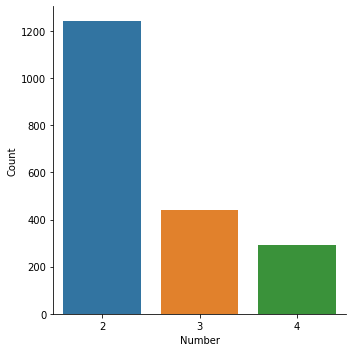

In [ ]:
sns.catplot(data = data_count,
           x = 'Number', y = 'Count',
           kind = 'bar')

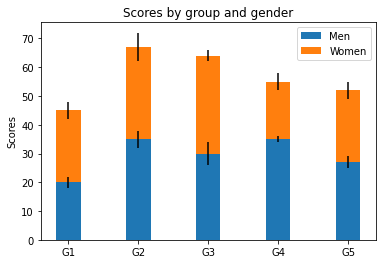

In [ ]:
import matplotlib.pyplot as plt

labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 35, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]
men_std = [2, 3, 4, 1, 2]
women_std = [3, 5, 2, 3, 3]
width = 0.35

fig, ax = plt.subplots()
ax.bar(labels, men_means, width, yerr = men_std, label = 'Men')
ax.bar(labels, women_means, width, yerr = women_std, bottom = men_means,
      label = 'Women')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.legend()

plt.show()

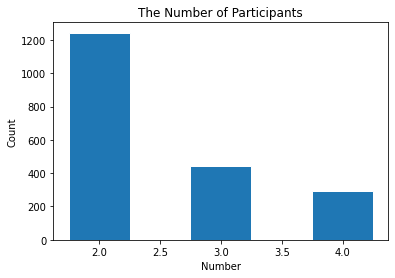

In [ ]:
plt.figure()
plt.bar(data_count.Number, data_count.Count,
        width = 0.5, edgecolor = 'white'
        )
plt.xlabel('Number')
plt.ylabel('Count')
plt.title('The Number of Participants')
plt.savefig('The Number of Participants')

**2명: 1243명, 3명: 440명, 4명: 290명**

- 화자 성별 추출

In [ ]:
data = [tuple(sorted(list(extract_speakers(file).values()))) for file in filelist]

In [ ]:
Keys = list(collections.Counter(data).keys())
keys = []
for Key in Keys:
    keys.append(list(map(lambda x: 'F' if x == '여성' else 'M', Key)))
Values = list(collections.Counter(data).values())

In [ ]:
keys

[['F', 'F'],
 ['M', 'M', 'F', 'F'],
 ['M', 'F', 'F', 'F'],
 ['M', 'F'],
 ['M', 'F', 'F'],
 ['F', 'F', 'F'],
 ['F', 'F', 'F', 'F'],
 ['M', 'M', 'F'],
 ['M', 'M', 'M'],
 ['M', 'M'],
 ['M', 'M', 'M', 'F'],
 ['M', 'M', 'M', 'M']]

In [ ]:
data_sex = pd.DataFrame({'category': keys, 'count': Values})

In [ ]:
data_sex['Number'] = pd.Series(map(lambda x: len(x), data_sex['category']))

In [ ]:
data_sex

,category,count,Number
0,"[F, F]",527,2
1,"[M, M, F, F]",29,4
2,"[M, F, F, F]",98,4
3,"[M, F]",335,2
4,"[M, F, F]",131,3
5,"[F, F, F]",193,3
6,"[F, F, F, F]",154,4
7,"[M, M, F]",51,3
8,"[M, M, M]",65,3
9,"[M, M]",381,2


In [ ]:
data_sex_count = pd.merge(data_sex, data_count)

In [ ]:
data_sex_count.drop('Count', axis = 1)

,category,count,Number
0,"[F, F]",527,2
1,"[M, F]",335,2
2,"[M, M]",381,2
3,"[M, M, F, F]",29,4
4,"[M, F, F, F]",98,4
5,"[F, F, F, F]",154,4
6,"[M, M, M, F]",6,4
7,"[M, M, M, M]",3,4
8,"[M, F, F]",131,3
9,"[F, F, F]",193,3


In [ ]:
data_sex_count['category'] = pd.Series(map(lambda x: str(x), data_sex_count['category']))

<Axes: xlabel='Number', ylabel='Count'>

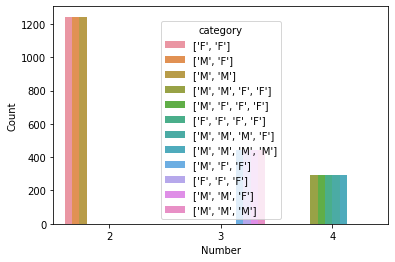

In [ ]:
sns.barplot(data = data_sex_count,
           x = 'Number',
           y = 'Count',
           hue = 'category')

Text(0.5, 1.0, 'The Number of Participants')

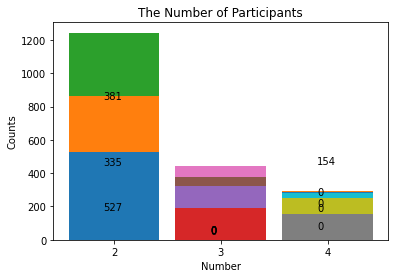

In [ ]:
labels = [2, 3, 4]
F_F = [527, 0, 0]
F_M = [335, 0, 0]
M_M = [381, 0, 0]
F_F_F = [0, 193, 0]
F_F_M = [0, 131, 0]
F_M_M = [0, 51, 0]
M_M_M = [0, 65, 0]
F_F_F_F = [0, 0, 154]
F_F_F_M = [0, 0, 98]
F_F_M_M = [0, 0, 29]
F_M_M_M = [0, 0, 6]
M_M_M_M = [0, 0, 3]

width = 0.85

fig, ax = plt.subplots()
ax.bar(labels, F_F, width)
ax.bar(labels, F_M, width, bottom = F_F)
ax.bar(labels, M_M, width, bottom = np.array(F_M) + np.array(F_F))

ax.bar(labels, F_F_F, width)
ax.bar(labels, F_F_M, width, bottom = F_F_F)
ax.bar(labels, F_M_M, width, bottom = np.array(F_F_F) + np.array(F_F_M))
ax.bar(labels, M_M_M, width, bottom = np.array(F_F_F) + np.array(F_F_M) + np.array(F_M_M))

ax.bar(labels, F_F_F_F, width)
ax.bar(labels, F_F_F_M, width, bottom = F_F_F_F)
ax.bar(labels, F_F_M_M, width, bottom = np.array(F_F_F_F) + np.array(F_F_F_M))
ax.bar(labels, F_M_M_M, width, bottom = np.array(F_F_F_F) + np.array(F_F_F_M) + np.array(F_F_M_M))
ax.bar(labels, M_M_M_M, width, bottom = np.array(F_F_F_F) + np.array(F_F_F_M) + np.array(F_F_M_M) + np.array(F_M_M_M))

ax.set_xticks([2, 3, 4])

stack = 0
pre_i = int()
for i, sex in zip(data_sex_count['Number'], [F_F, F_M, M_M, F_F_F, F_F_M, F_M_M, M_M_M, F_F_F_F, F_F_F_M, F_F_M_M, F_M_M_M, M_M_M_M]):
    if pre_i == i:
        stack += np.sum(sex)
        ax.annotate(f'{sex[i-2]}', [i - 0.1, np.mean(sex) + stack])
    else:
        ax.annotate(f'{sex[i - 2]}', [i - 0.1, np.mean(sex)])
        stack = 0
    pre_i = i


ax.set_ylabel('Counts')
ax.set_xlabel('Number')
ax.set_title('The Number of Participants')



In [ ]:
data_sex_count

,category,count,Number,Count
0,"['F', 'F']",527,2,1243
1,"['M', 'F']",335,2,1243
2,"['M', 'M']",381,2,1243
3,"['M', 'M', 'F', 'F']",29,4,290
4,"['M', 'F', 'F', 'F']",98,4,290
5,"['F', 'F', 'F', 'F']",154,4,290
6,"['M', 'M', 'M', 'F']",6,4,290
7,"['M', 'M', 'M', 'M']",3,4,290
8,"['M', 'F', 'F']",131,3,440
9,"['F', 'F', 'F']",193,3,440


- **화자가 2명인 경우**
    - **여성 & 여성: 427개**
    - **여성 & 남성: 335개**
    - **남성 & 남성: 381명**
- **화자가 3명인 경우**
    - **여성 & 여성 & 여성: 193개**
    - **여성 & 여성 & 남성: 131개**
    - **여성 & 남성 & 남성: 51개**
    - **남성 & 남성 & 남성: 65개**
- **화자가 4명인 경우**
    - **여성 & 여성 & 여성 & 여성: 154개**
    - **여성 & 여성 & 여성 & 남성: 98개**
    - **여성 & 여성 & 남성 & 남성: 29개**
    - **여성 & 남성  & 남성 & 남성: 6개**
    - **남성 & 남성 & 남성 & 남성: 3개**

**대화 참여 총 인원: 2168명**

- 억양구 길이 분포

In [ ]:
def token_into_dis(path):

    speakers, utterance = extract_speakers(path), extract_utterance(path)
    IP = dict()


    for speaker in speakers:
        sns.histplot(utterance[utterance['speaker_id'] == speaker]['token_count'])
        IP[speaker] = list(utterance[utterance['speaker_id'] == speaker]['token_count'])

    return speakers, IP

In [ ]:
tokens, IP = token_into_dis(filelist[-1])

TypeError: 'StandardScaler' object is not callable

In [ ]:
tokens, IP

({'SD2302167': '남성', 'SD2302168': '남성'},
 {'SD2302167': [14,
   3,
   12,
   9,
   14,
   9,
   10,
   4,
   11,
   14,
   8,
   7,
   7,
   14,
   13,
   4,
   19,
   14,
   15,
   4,
   17,
   13,
   6,
   12,
   6,
   11,
   4,
   12,
   17,
   13,
   6,
   9,
   6,
   14,
   11,
   14,
   8,
   11,
   15,
   8,
   4,
   11,
   7,
   10,
   14,
   8,
   4,
   11,
   7,
   13,
   11,
   12,
   8,
   11,
   7,
   5,
   10,
   12,
   3,
   9,
   8,
   9,
   3,
   2,
   14,
   2,
   13,
   6,
   12,
   14,
   8,
   11,
   8,
   11,
   8,
   7,
   3,
   12,
   6,
   12,
   7,
   10,
   7,
   7,
   11,
   14,
   8,
   6,
   8,
   12,
   10,
   13,
   9,
   5,
   7,
   9,
   13,
   10,
   6,
   10,
   6,
   5,
   10,
   7,
   6,
   6,
   5,
   4,
   1,
   8,
   9,
   15,
   7,
   4,
   10,
   15,
   4,
   3,
   9,
   6,
   8,
   11,
   12,
   9,
   15,
   3,
   4,
   17,
   5,
   10,
   13,
   4,
   15,
   14,
   17,
   13,
   4,
   15,
   3,
   2,
   11,
   16,
   9,
   8,
   6,
   9,
   

- 전체 화자 억양구 분포

In [ ]:
np.mean([np.mean(extract_utterance(file)['token_count']) for file in filelist])

5.530285927503558

In [ ]:
np.mean([np.var(extract_utterance(file)['token_count']) for file in filelist])

9.436386529729536

In [ ]:
length = [count for file in filelist for count in extract_utterance(file)['token_count']]

Text(0.5, 1.0, 'IP length distribution')

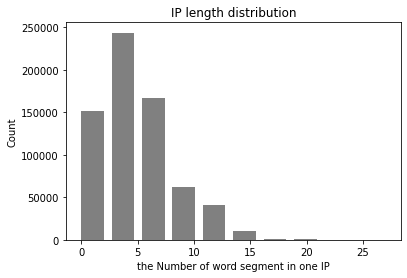

In [ ]:
plt.hist(length, width = 2, color = 'gray')

plt.xtickst(np.arange(25))

plt.xlabel('the Number of word segment in one IP')
plt.ylabel('Count')

plt.title('IP length distribution')
plt.savefig('./IP+length+distribution')

- 성별별 억양구 길이 분포

In [ ]:
extract_utterance(filelist[-1]).groupby(['speaker_id']).apply(lambda x: x)[['token_count', 'sex_M']]

token_count  sex_M
speaker_id                        
SD2302167  0             14   True
           1              3   True
           2             12   True
           3              9   True
           4             14   True
...                     ...    ...
SD2302168  245            8   True
           246            9   True
           247            3   True
           248           10   True
           249           13   True

[273 rows x 2 columns]

In [ ]:
utterance = extract_utterance(filelist[10]).groupby(['speaker_id']).apply(lambda x: x)
speakers = extract_speakers(filelist[10])


In [ ]:
utterance.loc[utterance['speaker_id'][0], ]['token_count']

C:\Users\AARONC~1\AppData\Local\Temp/ipykernel_25656/3875413759.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  utterance.loc[utterance['speaker_id'][0], ]['token_count']


24      5
25      6
26      9
27      6
28     10
       ..
364     5
365     3
366     3
367     3
368     3
Name: token_count, Length: 144, dtype: int64

C:\Users\Aaron Cho\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Aaron Cho\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


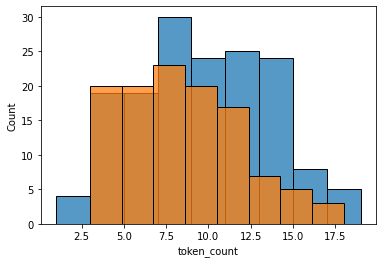

In [ ]:
tokens, IP = token_into_dis(filelist[-1])

C:\Users\Aaron Cho\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Aaron Cho\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


TypeError: string indices must be integers

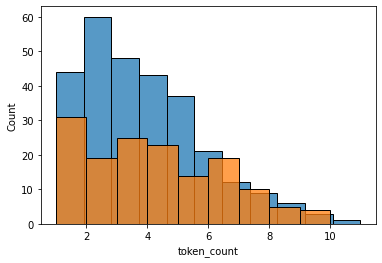

In [ ]:
female = [IP[speaker] for file_path in filelist for tokens, IP in token_into_dis(file_path) for speaker in IP if tokens[speaker] == '여성']


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

Array = np.arange(3, 300, 5).reshape(-1, 1)

In [ ]:
Array

array([[  3],
       [  8],
       [ 13],
       [ 18],
       [ 23],
       [ 28],
       [ 33],
       [ 38],
       [ 43],
       [ 48],
       [ 53],
       [ 58],
       [ 63],
       [ 68],
       [ 73],
       [ 78],
       [ 83],
       [ 88],
       [ 93],
       [ 98],
       [103],
       [108],
       [113],
       [118],
       [123],
       [128],
       [133],
       [138],
       [143],
       [148],
       [153],
       [158],
       [163],
       [168],
       [173],
       [178],
       [183],
       [188],
       [193],
       [198],
       [203],
       [208],
       [213],
       [218],
       [223],
       [228],
       [233],
       [238],
       [243],
       [248],
       [253],
       [258],
       [263],
       [268],
       [273],
       [278],
       [283],
       [288],
       [293],
       [298]])

In [ ]:
scaler.fit_transform(Array)

array([[-1.7034199 ],
       [-1.64567685],
       [-1.5879338 ],
       [-1.53019075],
       [-1.47244771],
       [-1.41470466],
       [-1.35696161],
       [-1.29921857],
       [-1.24147552],
       [-1.18373247],
       [-1.12598942],
       [-1.06824638],
       [-1.01050333],
       [-0.95276028],
       [-0.89501723],
       [-0.83727419],
       [-0.77953114],
       [-0.72178809],
       [-0.66404504],
       [-0.606302  ],
       [-0.54855895],
       [-0.4908159 ],
       [-0.43307286],
       [-0.37532981],
       [-0.31758676],
       [-0.25984371],
       [-0.20210067],
       [-0.14435762],
       [-0.08661457],
       [-0.02887152],
       [ 0.02887152],
       [ 0.08661457],
       [ 0.14435762],
       [ 0.20210067],
       [ 0.25984371],
       [ 0.31758676],
       [ 0.37532981],
       [ 0.43307286],
       [ 0.4908159 ],
       [ 0.54855895],
       [ 0.606302  ],
       [ 0.66404504],
       [ 0.72178809],
       [ 0.77953114],
       [ 0.83727419],
       [ 0

In [ ]:
collections.defaultdict(list)

defaultdict(list, {})

In [ ]:
def token_into_dist(path):
    from sklearn.preprocessing import StandardScaler
    import collections
    scaler = StandardScaler()
    tokens = collections.defaultdict(list)

    speakers, utterance = extract_speakers(path), extract_utterance(path)
    for speaker in speakers:
        counts = np.array(utterance[utterance['speaker_id'] == speaker]['token_count']).reshape(-1, 1)
        tokens[speaker] = counts
        sns.histplot(scaler.fit_transform(counts))

    return tokens

C:\Users\Aaron Cho\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Aaron Cho\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


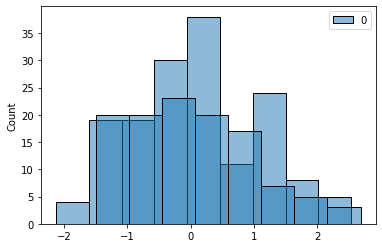

In [ ]:
tokens = token_into_dist(filelist[-1])

In [ ]:
tokens

defaultdict(list,
            {'SD2302167': array([[14],
                    [ 3],
                    [12],
                    [ 9],
                    [14],
                    [ 9],
                    [10],
                    [ 4],
                    [11],
                    [14],
                    [ 8],
                    [ 7],
                    [ 7],
                    [14],
                    [13],
                    [ 4],
                    [19],
                    [14],
                    [15],
                    [ 4],
                    [17],
                    [13],
                    [ 6],
                    [12],
                    [ 6],
                    [11],
                    [ 4],
                    [12],
                    [17],
                    [13],
                    [ 6],
                    [ 9],
                    [ 6],
                    [14],
                    [11],
                    [14],
                    [ 8],
       

- (2) Support Vector Regressor

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV


parameters = {'C': [0.001, 0.01, 1, 100],
             'epsilon': [0.1, 0.2, 0.3]}

grid_search = GridSearch(SVR(kernel = 'rbf'), parameters, scoring = 'neg_mean_squared_error')
grid_search.fit(x_train, y_train)
model = grid_search.best_estimator_

In [ ]:
def extract_speakers(path):
    #open json file and read
    with open(path, encoding = 'utf8') as f:
        sample = json.loads(f.read())

    #extract document
    document = sample['document'][0]

    #extract the speakers
    speakers = dict()
    for speaker in document['metadata']['speaker']:
        speakers[speaker['id']] = speaker['sex']

    return speakers

In [ ]:
def extract_length(path):
    #open json file and read
    with open(path, encoding = 'utf8') as f:
        sample = json.loads(f.read())


    #extract document and the utterance
    document = sample['document'][0]
    utterance = pd.DataFrame(document['utterance'])

    #extract the speakers and the utterances
    speakers = extract_speakers(path)

    #add up COUNT(the number of tokens within one intonational phrase), DURATION(the start and the end of one intonational phrase marked), SEX(the sex of the speaker)
    utterance['token_count'] = pd.Series(map(lambda x: len(x.split()), utterance['form']))
    utterance = utterance[['speaker_id', 'token_count']]

    return utterance

In [ ]:
extract_speakers(filelist[-1])

{'SD2302167': '남성', 'SD2302168': '남성'}

In [ ]:
extract_length(filelist[-1])

,speaker_id,token_count
0,SD2302167,14
1,SD2302167,3
2,SD2302167,12
3,SD2302167,9
4,SD2302167,14
...,...,...
268,SD2302167,11
269,SD2302167,9
270,SD2302167,13
271,SD2302167,7


In [ ]:
speakers = extract_speakers(filelist[-1])

In [ ]:
Speakers = speakers.copy()

In [ ]:
del Speakers['SD2302167']

In [ ]:
speakers

{'SD2302167': '남성', 'SD2302168': '남성'}

In [ ]:
Speakers

{'SD2302168': '남성'}

In [ ]:
file = filelist[-1]
speakers = extract_speakers(file)
token_count = extract_length(file)

os.makedir('./feats')
os.makedir('./labels')

for speaker_id in speakers:
    Speakers = speakers.copy()
    audience = del Speakers[speaker_id]

    file_path = os.splitext(file)[0]
    file_feat = os.path.join(os.getcwd(), 'feats', file_path, speaker_id, 'feats.txt')
    file_label = os.path.join(os.getcwd(), 'labels', file_path, speaker_id, 'labels.txt')

    speaker_sex = speakers[speaker_id]
    audience_sex = set(audience.values())
    num_parti = len(speakers)

    mean_counts = token_count.groupby(['speaker_id']).mean(['token_count'])[speaker]

    with open(file_feat, mode = 'w') as f_feat:
        f_feat.write('%s %d %s' % (speaker_sex, str(audience_sex), num_parti))
    with open(file_label, mode = 'w') as f_label:
        f_label.write('%d' % (mean_counts))

-----------------------------------
- (1) SVR process
    - 데이터 준비 (feats, labels)
    - SVR 진행
    - 결과 해석
- (2) 시각화
- 억양구 길이 분포
        - 전체
        - 성별별
        - 성별 명수별
- **proposal 수정**